# Set Up

In [1]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: C:\Users\xiayu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
plt.imshow??

In [4]:
#functional api import 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# Folder Structures

In [5]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
os.makedirs(POS_PATH, exist_ok = True)
os.makedirs(NEG_PATH, exist_ok = True)
os.makedirs(ANC_PATH, exist_ok = True)

# Collect positive and anchors

In [7]:
#Uncompress the GZ file
# !tar -xf lfw.tgz

# Move the Images to data/negative

In [8]:
# for directory in os.listdir('lfw'):
#     directory_path = os.path.join('lfw', directory)
#     for file in os.listdir(directory_path):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

# Collect Positive and Anchor Classes

In [9]:
#get unique id
import uuid

In [10]:
uuid.uuid1()

UUID('c296197c-3175-11ee-8e1b-c4bde5784b6d')

In [11]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    #resize frame
    frame = frame[100:120+250, 200:200+250, :]
    
    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #unique name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write img
        cv2.imwrite(imgname, frame)
        
        
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
         #write img
         cv2.imwrite(imgname, frame)

    cv2.imshow("Image Collection", frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
#release webcam and close image show frame
cap.release()
cv2.destroyAllWindows()

In [12]:
frame.shape

(270, 250, 3)

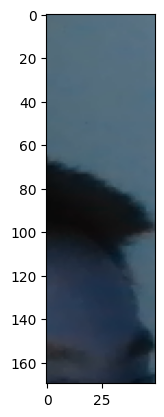

In [13]:
plt.imshow(frame[100:120+250, 200:200+250, :])

# Get Image Directories

In [14]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(300)

In [15]:
dir_test = anchor.as_numpy_iterator()

In [16]:
dir_test.next()

b'data\\anchor\\2d35b8c8-3009-11ee-b8f4-c4bde5784b6d.jpg'

# Preprocessing

In [17]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    #Preprocessing resizing the image to be 100X100X3
    img = tf.image.resize(img, (100,100))
    #scale image to be between 0 and 1
    img = img /255.0
    return img

In [18]:
img = preprocess('data\\anchor\\ffee009d-3008-11ee-9149-c4bde5784b6d.jpg')

In [19]:
img.numpy().max()

0.8734313

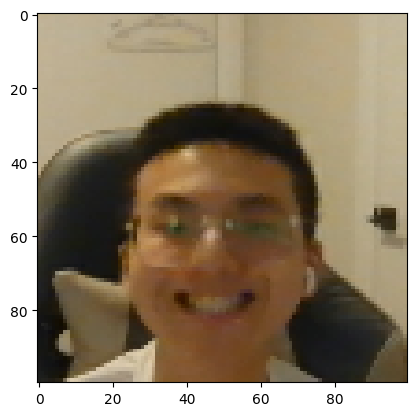

In [20]:
plt.imshow(img)

# Create Labelled Dataset

In [21]:
# (anchor, positive) => 1,1,1,1
# (anchor, negative) => 0,0,0,0

In [22]:
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [24]:
example = data.as_numpy_iterator()

In [25]:
sample = example.next()

# Build Train and Test Partition

In [26]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [27]:
res = preprocess_twin(*sample)

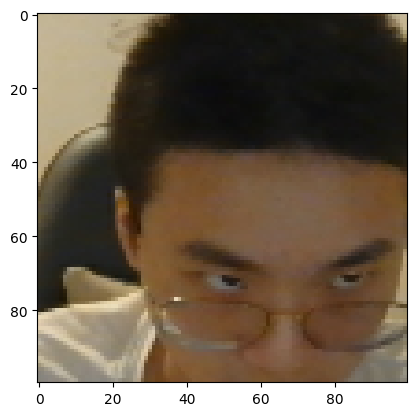

In [28]:
plt.imshow(res[0])

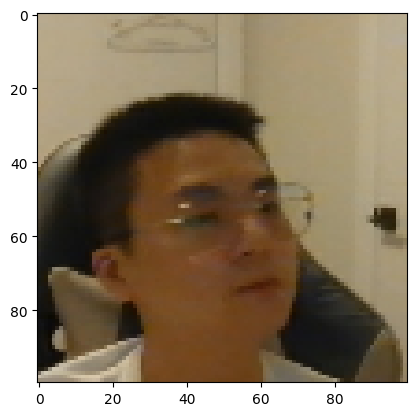

In [29]:
plt.imshow(res[1])

In [30]:
res[2]

1.0

In [31]:
#Build dataLoader Pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [32]:
samples = data.as_numpy_iterator()

In [33]:
sam = samples.next()

In [34]:
len(sam)

3

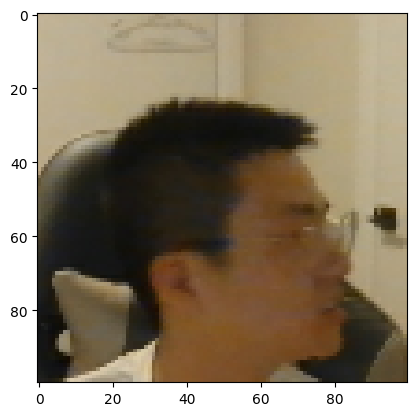

In [35]:
plt.imshow(sam[0])

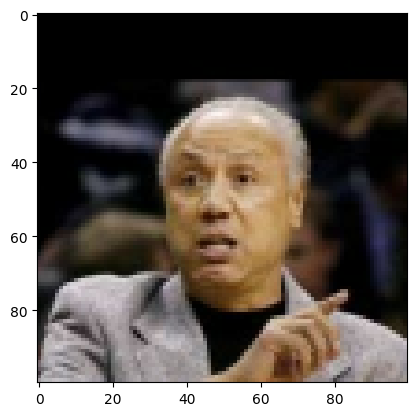

In [36]:
plt.imshow(sam[1])

In [37]:
sam[2]

0.0

In [38]:
#Training Partition
train_data = data.take(round(len(data)* .7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [39]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [40]:
samples = train_data.as_numpy_iterator()

In [41]:
sample = samples.next()

In [42]:
sample[0]

array([[[[0.7570098 , 0.70210785, 0.5962255 ],
         [0.7527941 , 0.6978921 , 0.59299016],
         [0.7490196 , 0.69411767, 0.5921569 ],
         ...,
         [0.7613235 , 0.71818626, 0.60838234],
         [0.7647059 , 0.72156864, 0.6117647 ],
         [0.7652941 , 0.7221568 , 0.6123529 ]],

        [[0.7486274 , 0.7001961 , 0.5921569 ],
         [0.7507843 , 0.7018137 , 0.5952941 ],
         [0.7473039 , 0.6967157 , 0.59475493],
         ...,
         [0.7612255 , 0.71848035, 0.6143628 ],
         [0.762549  , 0.72112745, 0.6143628 ],
         [0.762549  , 0.72156864, 0.6139216 ]],

        [[0.7610294 , 0.70612746, 0.6002451 ],
         [0.7558824 , 0.70098037, 0.595098  ],
         [0.7529412 , 0.69803923, 0.5921569 ],
         ...,
         [0.7647059 , 0.72156864, 0.6117647 ],
         [0.7637255 , 0.7205882 , 0.6107843 ],
         [0.7617647 , 0.71862745, 0.60882354]],

        ...,

        [[0.10980392, 0.10980392, 0.10196079],
         [0.10686275, 0.10686275, 0.09901961]

In [43]:
# test partition
test_data = data.skip(round(len(data)* .7))
test_data = test_data.take(round(len(data)* .3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering

## 1. build embedding layer
### Create a function

In [47]:
inp = Input(shape=(105,105,3), name = 'input_image')

In [48]:
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [51]:
c1 = Conv2D(64,(10,10), activation='relu')(inp)

In [52]:
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d')>

In [53]:
m1 = MaxPooling2D(64, (2,2), padding = "same")(c1)

In [54]:
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [55]:
c2 = Conv2D(128,(7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding = "same")(c2)
c3 = Conv2D(128,(4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding = "same")(c3)

In [57]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>

In [60]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation = 'sigmoid')(f1)

In [61]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

# By using function below the Model has build

In [63]:
def make_embedding():
    inp = Input(shape=(100,100,3), name = 'input_image')
    
    #first block
    c1 = Conv2D(64,(10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding = "same")(c1)
    
    #second
    c2 = Conv2D(128,(7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = "same")(c2)
    
    #third
    c3 = Conv2D(128,(4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = "same")(c3)
    
    #final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [72]:
embedding = make_embedding()

In [73]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

## 2. Build Distance Layer

In [74]:
#Siamese L1 Distance Class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    #important
    #Similarity Calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    

In [75]:
l1 = L1Dist()

In [86]:
input_image = Input(name='input_img', shape = (100,100,3))
    
#validation Img in the network
validation_image = Input(name = 'validation_img', shape = (100,100,3))

In [87]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

### put the input and validation img into embedding function that we declared before, the img will be modified

In [88]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [89]:
siamese_layer = L1Dist()

In [95]:
distances = siamese_layer(inp_embedding, val_embedding)

In [96]:
classifier = Dense(1, activation='sigmoid')(distances)

In [97]:
classifier  #Shape 1

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_4')>

In [98]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [100]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

### 1. input image validation image
### 2. goes to embedding(function)  layer
### 3. combined through L1Dist() layer
### 4. output a single value (shape 1)

### 4096 = distance between inp_embedding and val_embedding

## 3. Make Siamese Model

In [101]:
def make_siamese_model():
    #Handle Anchor Inputs in the network
    input_image = Input(name = 'input_img', shape = (100,100,3))
    
    #validation Img in the network
    validation_iamge = Input(name = 'validation_img', shape = (100,100,3))
    
    #Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    

In [103]:
siamese_model = make_siamese_model()

In [104]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Start To Training

## 1. Set up Loss and Optimizer

In [105]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [107]:
#Find keras Adam optimizer
opt = tf.keras.optimizers.Adam(1e-4)

## 2. Establish Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

## 3. Build Train Step Function

## 4. Build Training Loop

## 5. Train the Model